# MLP를 이용한 부도예측

## 데이터 불러오기

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import os

## 데이터 전처리 및 train, valid, test set 분리

In [165]:
def train_test_valid(file_name, valid=True):
    raw = pd.read_csv(f"{data_path}/{file_name}")
    
    # 데이터셋 분할
    from sklearn.model_selection import train_test_split
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(raw.iloc[:,:-1],raw.iloc[:,-1],
                                                       random_state = 1)
    
    if valid:
        X_train,X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.2,
                                                            random_state = 1)

        # 표준화
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        return X_train,X_valid,X_test,y_train,y_valid,y_test
    else:
         # 표준화
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        scaler = MinMaxScaler().fit(X_train_valid)
        X_train_valid = scaler.transform(X_train_valid)
        X_test = scaler.transform(X_test)
        
        return X_train_valid, X_test, y_train_valid, y_test

In [38]:
# 파라미터 초기화 설정
lucun_init = keras.initializers.VarianceScaling(scale=2.,
                                mode="fan_in",distribution="truncated_normal")

In [84]:
def get_score(X_test, y_test, term,model):
    predicted = model.predict((X_test, X_test[:,-10*term:])).round()
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test,predicted)
    recall = recall_score(y_test, predicted)
    confusion = confusion_matrix(y_test, predicted)
    roc = roc_auc_score(y_test, predicted)
    return accuracy, precision, recall, confusion, roc

### 클래스 개수의 균형 확인

In [326]:
y_train.value_counts()/y_train.value_counts().sum()

0    0.882135
1    0.117865
Name: CR, dtype: float64

## 년도별 accuracy, recall, precision, roc 비교

In [172]:
models = []
result = {}
valid = True

# 파일명 읽어오기
data_path = os.path.join(".","final_data")
file_names = os.listdir(data_path)

# 하이퍼 파라미터 지정
learning_rate = 1e-4
max_epoch = 50

for idx, file_name in enumerate(file_names):
    # 해당 파일의 년도 추출
    term = int(file_name.split("y")[0])
    print(f"{term}년도 데이터 훈련시작")
    
    # 데이터 분할
    X_train,X_valid,X_test, y_train,y_valid,y_test = train_test_valid(file_name, valid=True)
    
    # 모델 구현
    input_ = keras.layers.Input(shape = [X_train.shape[1]])
    input2_ = keras.layers.Input(shape = (10*term))
    hidden_layer1 = keras.layers.Dense(512, activation = "selu", kernel_initializer=lucun_init)(input_)
    hidden_layer2 = keras.layers.Dense(512, activation = "selu", kernel_initializer=lucun_init)(hidden_layer1)
    concat = keras.layers.concatenate([hidden_layer2, input2_])
    hidden_layer3 = keras.layers.Dense(256, activation = "selu", kernel_initializer=lucun_init)(concat)
    output_layer = keras.layers.Dense(1, activation = "sigmoid")(hidden_layer3)
    models.append(keras.Model(inputs = [input_, input2_], outputs = [output_layer]))
    
    # 모델 컴파일
    models[idx].compile(loss="binary_crossentropy", metrics="accuracy", optimizer = keras.optimizers.Adam(lr=learning_rate))
    
    # 모델 훈련
    history = models[idx].fit(x=[X_train,X_train[:,-10*term:]],y=y_train, epochs = max_epoch, 
                           validation_data = ((X_valid,X_valid[:,-10*term:]),y_valid),
                       class_weight = {0:0.1, 1:0.9}, batch_size = X_train.shape[0],validation_batch_size=X_valid.shape[0])
    
    # 모델 평가
    a={i:j for i,j in zip(["accuracy", "precision", "recall", "confusion", "roc"],get_score(X_test,y_test,term,models[idx]))}
    result[f"{term}year"]=a

10년도 데이터 훈련시작
Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.1630 - accuracy: 0.6615 - val_loss: 1.1242 - val_accuracy: 0.2214
Epoch 2/50
1/1 [==============================] - 1s 724ms/step - loss: 0.1525 - accuracy: 0.2209 - val_loss: 1.0802 - val_accuracy: 0.2545
Epoch 3/50
1/1 [==============================] - 0s 113ms/step - loss: 0.1442 - accuracy: 0.2522 - val_loss: 0.8348 - val_accuracy: 0.4582
Epoch 4/50
1/1 [==============================] - 0s 78ms/step - loss: 0.1297 - accuracy: 0.4462 - val_loss: 0.6263 - val_accuracy: 0.6605
Epoch 5/50
1/1 [==============================] - 0s 120ms/step - loss: 0.1231 - accuracy: 0.6605 - val_loss: 0.5301 - val_accuracy: 0.7473
Epoch 6/50
1/1 [==============================] - 0s 59ms/step - loss: 0.1203 - accuracy: 0.7435 - val_loss: 0.5202 - val_accuracy: 0.7518
Epoch 7/50
1/1 [==============================] - 0s 73ms/step - loss: 0.1141 - accuracy: 0.7503 - val_loss: 0.5642 - val_accuracy: 0.7114
Epoch 8/50
1

1/1 [==============================] - 0s 76ms/step - loss: 0.0843 - accuracy: 0.7258 - val_loss: 0.5121 - val_accuracy: 0.7494
Epoch 18/50
1/1 [==============================] - 0s 61ms/step - loss: 0.0828 - accuracy: 0.7351 - val_loss: 0.4830 - val_accuracy: 0.7614
Epoch 19/50
1/1 [==============================] - 0s 110ms/step - loss: 0.0811 - accuracy: 0.7519 - val_loss: 0.4495 - val_accuracy: 0.7843
Epoch 20/50
1/1 [==============================] - 0s 74ms/step - loss: 0.0800 - accuracy: 0.7710 - val_loss: 0.4253 - val_accuracy: 0.7975
Epoch 21/50
1/1 [==============================] - 0s 52ms/step - loss: 0.0794 - accuracy: 0.7872 - val_loss: 0.4169 - val_accuracy: 0.7987
Epoch 22/50
1/1 [==============================] - 0s 62ms/step - loss: 0.0788 - accuracy: 0.7922 - val_loss: 0.4238 - val_accuracy: 0.7957
Epoch 23/50
1/1 [==============================] - 0s 46ms/step - loss: 0.0778 - accuracy: 0.7892 - val_loss: 0.4403 - val_accuracy: 0.7873
Epoch 24/50
1/1 [==============

1/1 [==============================] - 0s 50ms/step - loss: 0.0729 - accuracy: 0.7779 - val_loss: 0.4485 - val_accuracy: 0.7868
Epoch 34/50
1/1 [==============================] - 0s 47ms/step - loss: 0.0722 - accuracy: 0.7829 - val_loss: 0.4281 - val_accuracy: 0.7955
Epoch 35/50
1/1 [==============================] - 0s 50ms/step - loss: 0.0714 - accuracy: 0.7922 - val_loss: 0.4068 - val_accuracy: 0.8050
Epoch 36/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0708 - accuracy: 0.8018 - val_loss: 0.3911 - val_accuracy: 0.8129
Epoch 37/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0704 - accuracy: 0.8096 - val_loss: 0.3847 - val_accuracy: 0.8181
Epoch 38/50
1/1 [==============================] - 0s 54ms/step - loss: 0.0699 - accuracy: 0.8135 - val_loss: 0.3879 - val_accuracy: 0.8172
Epoch 39/50
1/1 [==============================] - 0s 41ms/step - loss: 0.0692 - accuracy: 0.8135 - val_loss: 0.3980 - val_accuracy: 0.8129
Epoch 40/50
1/1 [===============

1/1 [==============================] - 0s 43ms/step - loss: 0.0515 - accuracy: 0.8662 - val_loss: 0.3768 - val_accuracy: 0.8410
Epoch 50/50
1/1 [==============================] - 0s 48ms/step - loss: 0.0511 - accuracy: 0.8696 - val_loss: 0.3674 - val_accuracy: 0.8471
17년도 데이터 훈련시작
Epoch 1/50
1/1 [==============================] - 1s 516ms/step - loss: 0.1789 - accuracy: 0.2057 - val_loss: 0.6676 - val_accuracy: 0.6177
Epoch 2/50
1/1 [==============================] - 0s 53ms/step - loss: 0.1512 - accuracy: 0.6538 - val_loss: 0.4858 - val_accuracy: 0.7879
Epoch 3/50
1/1 [==============================] - 0s 51ms/step - loss: 0.1457 - accuracy: 0.7885 - val_loss: 0.5256 - val_accuracy: 0.7599
Epoch 4/50
1/1 [==============================] - 0s 58ms/step - loss: 0.1270 - accuracy: 0.7483 - val_loss: 0.6735 - val_accuracy: 0.6154
Epoch 5/50
1/1 [==============================] - 0s 46ms/step - loss: 0.1167 - accuracy: 0.6224 - val_loss: 0.8142 - val_accuracy: 0.5385
Epoch 6/50
1/1 [======

1/1 [==============================] - 0s 85ms/step - loss: 0.0786 - accuracy: 0.8228 - val_loss: 0.4474 - val_accuracy: 0.8176
Epoch 16/50
1/1 [==============================] - 0s 70ms/step - loss: 0.0778 - accuracy: 0.8195 - val_loss: 0.4578 - val_accuracy: 0.8166
Epoch 17/50
1/1 [==============================] - 0s 80ms/step - loss: 0.0770 - accuracy: 0.8181 - val_loss: 0.4699 - val_accuracy: 0.8125
Epoch 18/50
1/1 [==============================] - 0s 76ms/step - loss: 0.0765 - accuracy: 0.8120 - val_loss: 0.4782 - val_accuracy: 0.8107
Epoch 19/50
1/1 [==============================] - 0s 72ms/step - loss: 0.0762 - accuracy: 0.8104 - val_loss: 0.4786 - val_accuracy: 0.8073
Epoch 20/50
1/1 [==============================] - 0s 88ms/step - loss: 0.0759 - accuracy: 0.8042 - val_loss: 0.4704 - val_accuracy: 0.7989
Epoch 21/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0756 - accuracy: 0.7986 - val_loss: 0.4562 - val_accuracy: 0.7961
Epoch 22/50
1/1 [===============

1/1 [==============================] - 0s 203ms/step - loss: 0.0802 - accuracy: 0.8294 - val_loss: 0.3835 - val_accuracy: 0.8268
Epoch 32/50
1/1 [==============================] - 0s 130ms/step - loss: 0.0804 - accuracy: 0.8333 - val_loss: 0.3801 - val_accuracy: 0.8291
Epoch 33/50
1/1 [==============================] - 0s 103ms/step - loss: 0.0801 - accuracy: 0.8343 - val_loss: 0.3853 - val_accuracy: 0.8258
Epoch 34/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0794 - accuracy: 0.8318 - val_loss: 0.3981 - val_accuracy: 0.8202
Epoch 35/50
1/1 [==============================] - 0s 118ms/step - loss: 0.0784 - accuracy: 0.8260 - val_loss: 0.4168 - val_accuracy: 0.8134
Epoch 36/50
1/1 [==============================] - 0s 88ms/step - loss: 0.0774 - accuracy: 0.8193 - val_loss: 0.4396 - val_accuracy: 0.8057
Epoch 37/50
1/1 [==============================] - 0s 61ms/step - loss: 0.0767 - accuracy: 0.8103 - val_loss: 0.4635 - val_accuracy: 0.7966
Epoch 38/50
1/1 [===========

1/1 [==============================] - 0s 137ms/step - loss: 0.0720 - accuracy: 0.8167 - val_loss: 0.4082 - val_accuracy: 0.8271
Epoch 48/50
1/1 [==============================] - 0s 134ms/step - loss: 0.0719 - accuracy: 0.8211 - val_loss: 0.4044 - val_accuracy: 0.8285
Epoch 49/50
1/1 [==============================] - 0s 200ms/step - loss: 0.0718 - accuracy: 0.8229 - val_loss: 0.4059 - val_accuracy: 0.8274
Epoch 50/50
1/1 [==============================] - 0s 160ms/step - loss: 0.0716 - accuracy: 0.8220 - val_loss: 0.4118 - val_accuracy: 0.8244
6년도 데이터 훈련시작
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.1680 - accuracy: 0.3467 - val_loss: 0.7238 - val_accuracy: 0.5192
Epoch 2/50
1/1 [==============================] - 0s 130ms/step - loss: 0.1469 - accuracy: 0.5255 - val_loss: 0.7703 - val_accuracy: 0.4808
Epoch 3/50
1/1 [==============================] - 0s 333ms/step - loss: 0.1324 - accuracy: 0.4832 - val_loss: 0.7484 - val_accuracy: 0.5302
Epoch 4/50
1/1 [==

1/1 [==============================] - 0s 158ms/step - loss: 0.0986 - accuracy: 0.8016 - val_loss: 0.4410 - val_accuracy: 0.8001
Epoch 14/50
1/1 [==============================] - 0s 193ms/step - loss: 0.0961 - accuracy: 0.7997 - val_loss: 0.4724 - val_accuracy: 0.7834
Epoch 15/50
1/1 [==============================] - 0s 95ms/step - loss: 0.0928 - accuracy: 0.7814 - val_loss: 0.5218 - val_accuracy: 0.7518
Epoch 16/50
1/1 [==============================] - 0s 63ms/step - loss: 0.0905 - accuracy: 0.7536 - val_loss: 0.5748 - val_accuracy: 0.7199
Epoch 17/50
1/1 [==============================] - 0s 84ms/step - loss: 0.0897 - accuracy: 0.7283 - val_loss: 0.6128 - val_accuracy: 0.6999
Epoch 18/50
1/1 [==============================] - 0s 64ms/step - loss: 0.0897 - accuracy: 0.7099 - val_loss: 0.6216 - val_accuracy: 0.6963
Epoch 19/50
1/1 [==============================] - 0s 84ms/step - loss: 0.0891 - accuracy: 0.7061 - val_loss: 0.6000 - val_accuracy: 0.7079
Epoch 20/50
1/1 [=============

In [173]:
pd.DataFrame(result)

,10year,11year,12year,13year,14year,15year,16year,17year,18year,1year,2year,3year,4year,5year,6year,7year,8year,9year
accuracy,0.816148,0.80902,0.816084,0.775641,0.82141,0.824315,0.850596,0.833799,0.820513,0.808764,0.793526,0.819522,0.824886,0.817224,0.815978,0.81623,0.80688,0.824885
precision,0.377114,0.373453,0.378747,0.304161,0.362105,0.358491,0.382488,0.375758,0.341463,0.373707,0.344523,0.373997,0.38273,0.368649,0.389527,0.374363,0.370256,0.380604
recall,0.887588,0.85347,0.837349,0.84127,0.815166,0.841772,0.741071,0.794872,0.756757,0.880203,0.888383,0.858722,0.87234,0.867347,0.89838,0.87415,0.865942,0.902386
confusion,"[[2613, 626], [48, 379]]","[[2269, 557], [57, 332]]","[[1985, 456], [54, 278]]","[[1603, 485], [40, 212]]","[[1401, 303], [39, 172]]","[[1101, 238], [25, 133]]","[[845, 134], [29, 83]]","[[535, 103], [16, 62]]","[[260, 54], [9, 28]]","[[5777, 1453], [118, 867]]","[[5300, 1484], [98, 780]]","[[5136, 1170], [115, 699]]","[[4780, 1058], [96, 656]]","[[4368, 1019], [91, 595]]","[[3935, 956], [69, 610]]","[[3630, 859], [74, 514]]","[[3228, 813], [74, 478]]","[[2985, 677], [45, 416]]"
roc,0.847159,0.828186,0.82527,0.804495,0.818674,0.832014,0.802099,0.816715,0.792391,0.839617,0.834816,0.836592,0.845557,0.839094,0.851459,0.841397,0.832377,0.858757


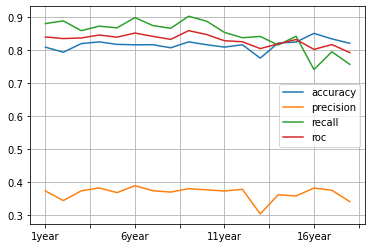

In [178]:
a=[f"{i}year" for i in range(1,19)]
result_df = pd.DataFrame(result)[a]

result_df.T.plot()
plt.grid()

- 9개년의 recall이 가장 높음

## 9개년 데이터를 사용한 MLP 최종 모델
- best_term : 9

In [179]:
import os
root_logdir = os.path.join(os.curdir, "final_tensorboard")

# 루트 로그 디렉터리와 현재 날짜와 시간을 이용한 서브 디렉터리 생성하는 함수
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id) # 디렉토리 주소를 반환

run_logdir = get_run_logdir() # 새로 그래프를 생성하려고 할 때마다 이 것을 실행해 주어야 함 

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint("final_mlp_best_model.h5",
                                               save_best_only = True)

In [180]:
best_term = 9 # 가장 성능이 좋은 term
X_train, X_test, y_train,y_test = train_test_valid(f"{best_term}year.csv",valid=False)

# 하이퍼 파라미터 지정
learning_rate = 1e-4
max_epoch = 100

input_ = keras.layers.Input(shape = X_train.shape[1:])
input2_ = keras.layers.Input(shape = (10*best_term,))
hidden_layer1 = keras.layers.Dense(512, activation = "selu", kernel_initializer=lucun_init)(input_)
hidden_layer2 = keras.layers.Dense(512, activation = "selu", kernel_initializer=lucun_init)(hidden_layer1)
concat = keras.layers.concatenate([hidden_layer2, input2_])
hidden_layer3 = keras.layers.Dense(256, activation = "selu", kernel_initializer=lucun_init)(concat)
output_layer = keras.layers.Dense(1, activation = "sigmoid")(hidden_layer3)
final_model = keras.Model(inputs = [input_, input2_], outputs = [output_layer])

final_model.compile(loss="binary_crossentropy", metrics="accuracy", optimizer = keras.optimizers.Adam(lr=learning_rate))

history = final_model.fit(x=[X_train,X_train[:,-10*best_term:]],y=y_train, epochs = max_epoch, 
                           validation_data = ((X_test,X_test[:,-10*best_term:]),y_test),
                       class_weight = {0:0.1, 1:0.9}, batch_size = X_train.shape[0],validation_batch_size=X_test.shape[0],
                                 callbacks=[tensorboard_cb, checkpoint_cb])

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.1771 - accuracy: 0.7067 - val_loss: 1.0375 - val_accuracy: 0.3350
Epoch 2/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 129ms/step - loss: 0.1541 - accuracy: 0.3356 - val_loss: 1.2129 - val_accuracy: 0.2302
Epoch 3/100
1/1 [==============================] - 0s 116ms/step - loss: 0.1547 - accuracy: 0.2305 - val_loss: 1.0531 - val_accuracy: 0.2789
Epoch 4/100
1/1 [==============================] - 0s 181ms/step - loss: 0.1416 - accuracy: 0.2790 - val_loss: 0.7977 - val_accuracy: 0.4625
Epoch 5/100
1/1 [==============================] - 0s 150ms/step - loss: 0.1280 - accuracy: 0.4627 - val_loss: 0.6006 - val_accuracy: 0.6772
Epoch 6/100
1/1 [==============================] - 0s 125ms/step - loss: 0.1232 - accuracy: 0.6793 - val_loss: 0.5080 - val_accuracy: 0.7732
Epoch 7/100
1/1 [==============================] - 0s 198ms/step - loss: 0.1214 - acc

Epoch 57/100
1/1 [==============================] - 0s 271ms/step - loss: 0.0675 - accuracy: 0.8302 - val_loss: 0.4012 - val_accuracy: 0.8273
Epoch 58/100
1/1 [==============================] - 0s 136ms/step - loss: 0.0673 - accuracy: 0.8334 - val_loss: 0.3989 - val_accuracy: 0.8283
Epoch 59/100
1/1 [==============================] - 0s 112ms/step - loss: 0.0671 - accuracy: 0.8338 - val_loss: 0.4006 - val_accuracy: 0.8268
Epoch 60/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0669 - accuracy: 0.8336 - val_loss: 0.4050 - val_accuracy: 0.8259
Epoch 61/100
1/1 [==============================] - 0s 82ms/step - loss: 0.0667 - accuracy: 0.8326 - val_loss: 0.4094 - val_accuracy: 0.8242
Epoch 62/100
1/1 [==============================] - 0s 102ms/step - loss: 0.0665 - accuracy: 0.8311 - val_loss: 0.4112 - val_accuracy: 0.8237
Epoch 63/100
1/1 [==============================] - 0s 448ms/step - loss: 0.0663 - accuracy: 0.8305 - val_loss: 0.4094 - val_accuracy: 0.8239
Epoch 64

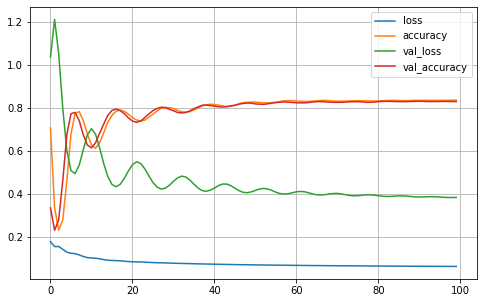

In [181]:
# 에포크가 끝날 때 마다의 train, valid set의 loss, 평가 지표
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True) # grid를 생성
#plt.gca().set_ylim(0,1) # 수직출의 범위를 0~1 사이로 설정
plt.show()

In [182]:
final_model = keras.models.load_model("final_mlp_best_model.h5") # 저장된 모델 불러오기

In [184]:
accuracy, precision, recall, matrix, roc = get_score(X_test,y_test,best_term,final_model)
print("accuracy : {:.2}".format(accuracy))
print("precision : {:.2}".format(precision))
print("recall : {:.2}".format(recall))
print("roc : {:.2}".format(roc))
print("confusion-matrics")
print(matrix)

accuracy : 0.83
precision : 0.39
recall : 0.89
roc : 0.85
confusion-matrics
[[3015  647]
 [  53  408]]
